In [7]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-cased"  # Changer ici pour `distilbert-base-cased`
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(label2id[example["ner_tags"][word_idx]])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


# 7. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 8. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 9. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 10. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 11. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 12. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 13. Entraînement
trainer.train()

# 14. Sauvegarde
trainer.save_model("./ner_model")

# 15. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_4956\311577081.py:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.227000,0.112458,0.973451,0.967538,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 54, 0, 15, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 7, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
2,0.073400,0.015271,0.997345,0.997309,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 68, 0, 0, 0, 1, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 2, 0, 0, 0, 13, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
3,0.044100,0.005365,1.000000,1.000000,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 0, 0, 0, 0, 15, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
4,0.094700,0.003904,1.000000,1.000000,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 0, 0, 0, 0, 15, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"


Trainer is attempting to log a value of "[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 54, 0, 15, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 7, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 190]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 68, 0, 0, 0, 1, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 2, 0, 0, 0, 13, 0], [0, 0, 0, 0, 0, 0, 0, 190]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. Thi

Trainer is attempting to log a value of "[[486, 0, 0, 0, 0, 0, 0, 0, 0], [0, 526, 0, 0, 0, 0, 0, 0, 0], [0, 0, 178, 0, 0, 0, 2, 0, 0], [0, 0, 0, 294, 0, 0, 0, 0, 0], [0, 0, 0, 0, 180, 0, 0, 0, 0], [0, 0, 0, 0, 0, 652, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 5, 0, 1, 0, 1, 0, 483]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9964
Test F1 Score = 0.9964


In [5]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-cased"  # Changer ici pour `distilbert-base-cased`
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(label2id[example["ner_tags"][word_idx]])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 5. Fonction d'augmentation des données
def augment_data(example):
    augmented_example = example.copy()
    tokens = augmented_example["tokens"]
    ner_tags = augmented_example["ner_tags"]

    # 1. Modifier le nom du client et prénom
    if "nom_client" in ner_tags:
        name_idx = ner_tags.index("B-nom_client")
        tokens[name_idx] = random.choice(["Dupont", "Martin", "Lemoine", "Bernard"])  # Remplacer le nom

    if "prenom_client" in ner_tags:
        first_name_idx = ner_tags.index("B-prenom_client")
        tokens[first_name_idx] = random.choice(["Paul", "Pierre", "Marie", "Sophie"])  # Remplacer prénom

    # 2. Modifier les dates de début et de fin
    if "date_debut" in ner_tags:
        start_date_idx = ner_tags.index("B-date_debut")
        original_date = tokens[start_date_idx]
        start_date = datetime.strptime(original_date, "%Y-%m-%d")
        new_start_date = start_date + timedelta(days=random.randint(0, 365))  # Ajouter de 0 à 365 jours
        tokens[start_date_idx] = new_start_date.strftime("%Y-%m-%d")

    if "date_fin" in ner_tags:
        end_date_idx = ner_tags.index("B-date_fin")
        original_date = tokens[end_date_idx]
        end_date = datetime.strptime(original_date, "%Y-%m-%d")
        new_end_date = end_date + timedelta(days=random.randint(0, 365))  # Ajouter de 0 à 365 jours
        tokens[end_date_idx] = new_end_date.strftime("%Y-%m-%d")

    # 3. Modifier les numéros de compte (ici, ajouter un bruit numérique)
    if "num_compte" in ner_tags:
        account_idx = ner_tags.index("B-num_compte")
        tokens[account_idx] = str(random.randint(10000000000, 99999999999))  # Générer un nouveau numéro de compte

    # 4. Modifier les rib (ici, ajouter un bruit numérique)
    if "rib" in ner_tags:
        rib_idx = ner_tags.index("B-rib")
        tokens[rib_idx] = str(random.randint(10000000000458210201, 99999999999999999999))  # Générer un nouveau rib

    augmented_example["tokens"] = tokens
    return augmented_example

# 6. Appliquer l'augmentation sur le dataset
augmented_data = [augment_data(example) for example in converted_data]

# Fusionner les données originales et augmentées
full_data = converted_data + augmented_data
# 7. Dataset HuggingFace
dataset = Dataset.from_list(full_data)
dataset = dataset.map(tokenize_and_align_labels)

# 8. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 9. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 10. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 11. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 12. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 13. Entraînement
trainer.train()

# 14. Sauvegarde
trainer.save_model("./ner_model")

# 15. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


ERROR! Session/line number was not unique in database. History logging moved to new session 172


Map:   0%|          | 0/934 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_4956\491500817.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.026300,0.013212,0.995467,0.995274,"[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 130, 0, 0, 0, 2, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 8, 0, 0, 0, 23, 0], [0, 0, 0, 0, 0, 0, 0, 375]]"
2,0.036200,0.001907,1.000000,1.000000,"[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 132, 0, 0, 0, 0, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 0, 0, 0, 0, 31, 0], [0, 0, 0, 0, 0, 0, 0, 375]]"
3,0.011900,0.001393,1.000000,1.000000,"[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 132, 0, 0, 0, 0, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 0, 0, 0, 0, 31, 0], [0, 0, 0, 0, 0, 0, 0, 375]]"
4,0.015400,0.001124,1.000000,1.000000,"[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 132, 0, 0, 0, 0, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 0, 0, 0, 0, 31, 0], [0, 0, 0, 0, 0, 0, 0, 375]]"


Trainer is attempting to log a value of "[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 130, 0, 0, 0, 2, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 8, 0, 0, 0, 23, 0], [0, 0, 0, 0, 0, 0, 0, 375]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[390, 0, 0, 0, 0, 0, 0, 0], [0, 426, 0, 0, 0, 0, 0, 0], [0, 0, 132, 0, 0, 0, 0, 0], [0, 0, 0, 287, 0, 0, 0, 0], [0, 0, 0, 0, 143, 0, 0, 0], [0, 0, 0, 0, 0, 422, 0, 0], [0, 0, 0, 0, 0, 0, 31, 0], [0, 0, 0, 0, 0, 0, 0, 375]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar.

Trainer is attempting to log a value of "[[967, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1059, 0, 0, 0, 0, 0, 0, 0], [0, 0, 345, 0, 0, 0, 0, 0, 0], [0, 0, 0, 651, 0, 0, 0, 0, 0], [0, 0, 0, 0, 386, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1194, 0, 0, 0], [0, 0, 0, 0, 0, 0, 57, 0, 0], [0, 0, 0, 0, 3, 0, 0, 0, 0], [0, 0, 10, 0, 2, 0, 1, 0, 961]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9972
Test F1 Score = 0.9969


# Tripler artificiellement la taille du dataset

In [6]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-cased"  # Changer ici pour `distilbert-base-cased`
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(label2id[example["ner_tags"][word_idx]])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 5. Fonction d'augmentation des données
def augment_data(example):
    augmented_example = example.copy()
    tokens = augmented_example["tokens"]
    ner_tags = augmented_example["ner_tags"]

    # 1. Modifier le nom du client et prénom
    if "nom_client" in ner_tags:
        name_idx = ner_tags.index("B-nom_client")
        tokens[name_idx] = random.choice(["Dupont", "Martin", "Lemoine", "Bernard"])  # Remplacer le nom

    if "prenom_client" in ner_tags:
        first_name_idx = ner_tags.index("B-prenom_client")
        tokens[first_name_idx] = random.choice(["Paul", "Pierre", "Marie", "Sophie"])  # Remplacer prénom

    # 2. Modifier les dates de début et de fin
    if "date_debut" in ner_tags:
        start_date_idx = ner_tags.index("B-date_debut")
        original_date = tokens[start_date_idx]
        start_date = datetime.strptime(original_date, "%Y-%m-%d")
        new_start_date = start_date + timedelta(days=random.randint(0, 365))  # Ajouter de 0 à 365 jours
        tokens[start_date_idx] = new_start_date.strftime("%Y-%m-%d")

    if "date_fin" in ner_tags:
        end_date_idx = ner_tags.index("B-date_fin")
        original_date = tokens[end_date_idx]
        end_date = datetime.strptime(original_date, "%Y-%m-%d")
        new_end_date = end_date + timedelta(days=random.randint(0, 365))  # Ajouter de 0 à 365 jours
        tokens[end_date_idx] = new_end_date.strftime("%Y-%m-%d")

    # 3. Modifier les numéros de compte (ici, ajouter un bruit numérique)
    if "num_compte" in ner_tags:
        account_idx = ner_tags.index("B-num_compte")
        tokens[account_idx] = str(random.randint(10000000000, 99999999999))  # Générer un nouveau numéro de compte

    # 4. Modifier les rib (ici, ajouter un bruit numérique)
    if "rib" in ner_tags:
        rib_idx = ner_tags.index("B-rib")
        tokens[rib_idx] = str(random.randint(10000000000458210201, 99999999999999999999))  # Générer un nouveau rib

    augmented_example["tokens"] = tokens
    return augmented_example

# 6. Appliquer l'augmentation sur le dataset
augmented_data = []
AUG_PER_SAMPLE = 3  # Générer 3 augmentations par échantillon

for example in converted_data:
    augmented_data.append(example)  # Ajouter l'original
    for _ in range(AUG_PER_SAMPLE):
        augmented_data.append(augment_data(example))


# Fusionner les données originales et augmentées
full_data = converted_data + augmented_data
# 7. Dataset HuggingFace
dataset = Dataset.from_list(full_data)
dataset = dataset.map(tokenize_and_align_labels)

# 8. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 9. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 10. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 11. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 12. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 13. Entraînement
trainer.train()

# 14. Sauvegarde
trainer.save_model("./ner_model")

# 15. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/2335 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_4956\1268731858.py:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.007300,0.020360,0.995492,0.994059,"[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1024, 0, 0, 0, 9], [0, 0, 0, 0, 0, 0, 64, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 13, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 953]]"
2,0.001200,0.001520,1.000000,1.000000,"[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1033, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 64, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 953]]"
3,0.000700,0.000595,1.000000,1.000000,"[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1033, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 64, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 953]]"
4,0.000800,0.000390,1.000000,1.000000,"[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1033, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 64, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 953]]"


Trainer is attempting to log a value of "[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1024, 0, 0, 0, 9], [0, 0, 0, 0, 0, 0, 64, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 13, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 953]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[966, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1056, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 353, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 716, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 389, 0, 0, 0, 0, 0], [0, 0

Trainer is attempting to log a value of "[[2413, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2630, 0, 0, 0, 0, 0, 0, 0], [0, 0, 836, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1476, 0, 0, 0, 0, 0], [0, 0, 0, 0, 897, 0, 0, 0, 0], [0, 0, 0, 0, 0, 3192, 0, 0, 0], [0, 0, 0, 0, 0, 0, 158, 0, 0], [0, 0, 0, 0, 0, 0, 0, 6, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2335]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 1.0000
Test F1 Score = 1.0000


# Chnager learning rate de learning_rate=2e-5 à learning_rate=1e-4

In [16]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "bert-base-cased"  # Changer ici pour `distilbert-base-cased`
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(label2id[example["ner_tags"][word_idx]])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


# 7. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 8. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 9. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 10. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 11. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 12. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 13. Entraînement
trainer.train()

# 14. Sauvegarde
trainer.save_model("./ner_model")

# 15. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_4956\3133815346.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.382600,0.227005,0.929204,0.910060,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 64, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 76, 0, 0, 1], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 1, 0, 14, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
2,0.125300,0.036085,0.998230,0.998180,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 2, 0, 0, 0, 13, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
3,0.060400,0.011610,1.000000,1.000000,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 0, 0, 0, 0, 15, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"
4,0.113900,0.010117,1.000000,1.000000,"[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 0, 0, 0, 0, 15, 0], [0, 0, 0, 0, 0, 0, 0, 190]]"


Trainer is attempting to log a value of "[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 64, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 76, 0, 0, 1], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 1, 0, 14, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 190]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[192, 0, 0, 0, 0, 0, 0, 0], [0, 219, 0, 0, 0, 0, 0, 0], [0, 0, 69, 0, 0, 0, 0, 0], [0, 0, 0, 126, 0, 0, 0, 0], [0, 0, 0, 0, 77, 0, 0, 0], [0, 0, 0, 0, 0, 242, 0, 0], [0, 0, 2, 0, 0, 0, 13, 0], [0, 0, 0, 0, 0, 0, 0, 190]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. Thi

Trainer is attempting to log a value of "[[486, 0, 0, 0, 0, 0, 0, 0, 0], [0, 526, 0, 0, 0, 0, 0, 0, 0], [0, 0, 174, 0, 0, 0, 6, 0, 0], [0, 0, 0, 294, 0, 0, 0, 0, 0], [0, 0, 0, 0, 180, 0, 0, 0, 0], [0, 0, 0, 0, 0, 652, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 13, 0, 2, 0, 474]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9918
Test F1 Score = 0.9922


# Augmented data


In [35]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

# 1. Charger le modèle et le tokenizer
model_checkpoint = "./"  # Remplacez par le chemin vers votre modèle sauvegardé
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

# 2. Exemple à tester
example = {
    "tokens": [
        "Paris", ",", "Anaïs", ",", "20928021152", ",", "du", "2018-08-20", "au", "2022-11-05"
    ]
}

# 3. Tokenisation
inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True, return_tensors="pt")

# 4. Prédiction
with torch.no_grad():
    model.eval()
    outputs = model(**inputs)
    logits = outputs.logits

# 5. Extraire les prédictions
predictions = torch.argmax(logits, dim=-1)

# 6. Convertir les indices de prédiction en étiquettes
predicted_labels = [model.config.id2label[pred.item()] for pred in predictions[0]]

# 7. Afficher les résultats
for token, label in zip(example["tokens"], predicted_labels):
    print(f"Token: {token} => Predicted Label: {label}")


Token: Paris => Predicted Label: O
Token: , => Predicted Label: B-nom_client
Token: Anaïs => Predicted Label: O
Token: , => Predicted Label: B-prenom_client
Token: 20928021152 => Predicted Label: B-prenom_client
Token: , => Predicted Label: O
Token: du => Predicted Label: B-num_compte
Token: 2018-08-20 => Predicted Label: B-num_compte
Token: au => Predicted Label: B-num_compte
Token: 2022-11-05 => Predicted Label: B-num_compte


In [1]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset_multiword.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 5. Tokenisation et alignement des labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            # Subword => ignorer
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 7. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 8. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 9. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 10. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# 11. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 12. Entraînement
trainer.train()

# 13. Sauvegarde
trainer.save_model("./ner_model1")

# 14. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/1364 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_8240\1786301314.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.220400,0.106336,0.986919,0.987009,"[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 184, 0, 5, 2, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 10, 0, 0, 0, 74, 0, 0], [0, 0, 0, 0, 2, 0, 3, 65, 0], [0, 0, 0, 0, 0, 0, 5, 0, 950]]"
2,0.034100,0.012670,0.998547,0.998548,"[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 190, 0, 0, 1, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 0, 0, 1, 0, 83, 0, 0], [0, 0, 0, 0, 0, 0, 0, 70, 0], [0, 0, 0, 0, 0, 0, 1, 0, 954]]"
3,0.027600,0.007167,0.999516,0.999515,"[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 191, 0, 0, 0, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 0, 0, 1, 0, 83, 0, 0], [0, 0, 0, 0, 0, 0, 0, 70, 0], [0, 0, 0, 0, 0, 0, 0, 0, 955]]"
4,0.012000,0.006212,0.999031,0.999033,"[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 190, 0, 0, 1, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 0, 0, 0, 0, 84, 0, 0], [0, 0, 0, 0, 0, 0, 0, 70, 0], [0, 0, 0, 0, 0, 0, 1, 0, 954]]"
5,0.013300,0.006004,0.999031,0.999033,"[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 190, 0, 0, 1, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 0, 0, 0, 0, 84, 0, 0], [0, 0, 0, 0, 0, 0, 0, 70, 0], [0, 0, 0, 0, 0, 0, 1, 0, 954]]"


Trainer is attempting to log a value of "[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 184, 0, 5, 2, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 10, 0, 0, 0, 74, 0, 0], [0, 0, 0, 0, 2, 0, 3, 65, 0], [0, 0, 0, 0, 0, 0, 5, 0, 950]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[191, 0, 0, 0, 0, 0, 0, 0, 0], [0, 191, 0, 0, 0, 0, 0, 0, 0], [0, 0, 191, 0, 0, 0, 0, 0, 0], [0, 0, 0, 94, 0, 0, 0, 0, 0], [0, 0, 0, 0, 190, 0, 0, 1, 0], [0, 0, 0, 0, 0, 97, 0, 0, 0], [0, 0, 0, 0, 1, 0, 83, 0, 0], [0, 0, 0, 0, 0, 0, 0, 70

Trainer is attempting to log a value of "[[410, 0, 0, 0, 0, 0, 0, 0, 0], [0, 410, 0, 0, 0, 0, 0, 0, 0], [0, 0, 410, 0, 0, 0, 0, 0, 0], [0, 0, 0, 216, 0, 1, 0, 0, 0], [0, 0, 0, 0, 408, 0, 1, 1, 0], [0, 0, 0, 0, 0, 193, 0, 0, 0], [0, 0, 0, 0, 0, 0, 180, 0, 4], [0, 0, 0, 0, 2, 0, 0, 161, 0], [0, 0, 0, 0, 1, 0, 1, 1, 2049]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9973
Test F1 Score = 0.9973


# Augmentation Complexe et Bruitée des Données pour la Reconnaissance d'Entités Nommées
Ajoute les éléments suivants dans les exemples :

Variété de noms et prénoms (hommes, femmes, doubles prénoms, prénoms rares)

Divers numéros de compte et RIB (valeurs aléatoires mais crédibles)

Dates au format AAAA-MM-JJ

Mots inutiles et phrases parasites (ex. : "Bonjour", "Merci de vérifier", "Ce client a été validé par le service juridique.")

Erreurs typographiques légères (ex. : "compte banquaire", "Mr." au lieu de "Monsieur")

Ponctuation variée, parfois absente ou mal placée

Ordre aléatoire des entités dans les phrases

Présence de phrases sans entités (juste du texte générique ou bruité)

In [13]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset_augmented_plus1400_final.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 5. Tokenisation et alignement des labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            # Subword => ignorer
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 7. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 8. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 9. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 10. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs2",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_safetensors=False
)

# 11. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# 12. Entraînement
trainer.train()

# 13. Sauvegarde
trainer.save_model("./ner_model2")

# 14. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/2767 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_8240\2011414539.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.182900,0.141213,0.948784,0.946981,"[[261, 78, 0, 0, 0, 0, 0, 0, 0, 0], [38, 315, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 332, 0, 15, 0, 0, 0, 0, 1], [0, 0, 0, 233, 0, 23, 0, 0, 0, 0], [0, 0, 7, 0, 344, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 9, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
2,0.077400,0.074485,0.973391,0.973035,"[[297, 42, 0, 0, 0, 0, 0, 0, 0, 0], [38, 315, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 345, 0, 2, 0, 0, 0, 0, 1], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 7, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
3,0.074000,0.062130,0.973677,0.973377,"[[311, 28, 0, 0, 0, 0, 0, 0, 0, 0], [55, 298, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
4,0.047600,0.058168,0.977110,0.976829,"[[303, 36, 0, 0, 0, 0, 0, 0, 0, 0], [36, 317, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
5,0.040900,0.059144,0.975680,0.975400,"[[305, 34, 0, 0, 0, 0, 0, 0, 0, 0], [43, 310, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"


Trainer is attempting to log a value of "[[261, 78, 0, 0, 0, 0, 0, 0, 0, 0], [38, 315, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 332, 0, 15, 0, 0, 0, 0, 1], [0, 0, 0, 233, 0, 23, 0, 0, 0, 0], [0, 0, 7, 0, 344, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 9, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[297, 42, 0, 0, 0, 0, 0, 0, 0, 0], [38, 315, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 345, 0, 2, 0, 0, 0, 0, 1], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0,

Trainer is attempting to log a value of "[[639, 115, 0, 0, 0, 0, 0, 0], [84, 682, 0, 0, 0, 0, 0, 0], [0, 0, 761, 0, 3, 0, 0, 0], [0, 0, 0, 583, 0, 0, 0, 0], [0, 0, 3, 0, 758, 0, 0, 1], [0, 0, 0, 0, 0, 549, 0, 0], [0, 0, 0, 0, 0, 0, 20, 0], [0, 0, 0, 0, 0, 0, 0, 3430]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9730
Test F1 Score = 0.9730


In [17]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset_augmented_plus1900_final_composes_balanced.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 5. Tokenisation et alignement des labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            # Subword => ignorer
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 7. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 8. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 9. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 10. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs2",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_safetensors=False
)

# 11. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 12. Entraînement
trainer.train()

# 13. Sauvegarde
trainer.save_model("./ner_model2")

# 14. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/3267 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_11360\484172771.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.178700,0.127338,0.951703,0.951165,"[[297, 119, 0, 0, 0, 0, 0, 0, 0, 0], [25, 394, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 383, 0, 29, 0, 0, 0, 0, 0], [0, 0, 0, 329, 0, 8, 0, 0, 0, 0], [0, 0, 15, 0, 408, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 47, 5, 0, 0], [0, 0, 0, 0, 1, 0, 6, 45, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 3, 0, 0, 0, 0, 2055]]"
2,0.083100,0.062119,0.970844,0.970570,"[[394, 22, 0, 0, 0, 0, 0, 0, 0, 0], [90, 329, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 402, 0, 9, 0, 0, 0, 0, 1], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 418, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 53, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
3,0.039100,0.056059,0.975963,0.975668,"[[329, 87, 0, 0, 0, 0, 0, 0, 0, 0], [13, 406, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 409, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 421, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
4,0.033200,0.048748,0.978633,0.978493,"[[358, 58, 0, 0, 0, 0, 0, 0, 0, 0], [28, 391, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 409, 0, 2, 0, 0, 0, 0, 1], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 419, 0, 0, 0, 0, 2], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
5,0.030100,0.042334,0.982195,0.982083,"[[380, 36, 0, 0, 0, 0, 0, 0, 0, 0], [37, 382, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 411, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 420, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
6,0.043200,0.042857,0.981972,0.981859,"[[383, 33, 0, 0, 0, 0, 0, 0, 0, 0], [41, 378, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 411, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 420, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
7,0.029900,0.044028,0.981749,0.981622,"[[366, 50, 0, 0, 0, 0, 0, 0, 0, 0], [26, 393, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 411, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 421, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
8,0.017500,0.044448,0.983530,0.983413,"[[375, 41, 0, 0, 0, 0, 0, 0, 0, 0], [27, 392, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 411, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 421, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
9,0.016300,0.045231,0.982640,0.982526,"[[376, 40, 0, 0, 0, 0, 0, 0, 0, 0], [31, 388, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 410, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 421, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"
10,0.026000,0.045211,0.982862,0.982751,"[[381, 35, 0, 0, 0, 0, 0, 0, 0, 0], [36, 383, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 411, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 421, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 54, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 52, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 2059]]"


Trainer is attempting to log a value of "[[297, 119, 0, 0, 0, 0, 0, 0, 0, 0], [25, 394, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 383, 0, 29, 0, 0, 0, 0, 0], [0, 0, 0, 329, 0, 8, 0, 0, 0, 0], [0, 0, 15, 0, 408, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 318, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 47, 5, 0, 0], [0, 0, 0, 0, 1, 0, 6, 45, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 3, 0, 0, 0, 0, 2055]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[394, 22, 0, 0, 0, 0, 0, 0, 0, 0], [90, 329, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 402, 0, 9, 0, 0, 0, 0, 1], [0, 0, 0, 337, 0, 0, 0, 0, 0, 0], [0, 0, 4, 0, 418, 0, 0, 0, 0, 1], 

Trainer is attempting to log a value of "[[808, 98, 0, 0, 0, 0, 0, 0, 0], [66, 856, 0, 0, 0, 0, 0, 0, 0], [0, 0, 859, 0, 15, 0, 0, 0, 1], [0, 0, 0, 731, 0, 0, 0, 0, 0], [0, 0, 8, 0, 894, 0, 0, 0, 1], [0, 0, 0, 0, 0, 685, 0, 0, 0], [0, 0, 1, 0, 0, 0, 134, 0, 0], [0, 0, 0, 0, 0, 0, 0, 121, 0], [0, 0, 5, 0, 0, 0, 0, 0, 4345]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9797
Test F1 Score = 0.9797


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.nn.functional import softmax
import numpy as np

# Charger le modèle et le tokenizer
model_path = "./ner_model1"
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
id2label = model.config.id2label

model.eval()

def predict_entities(text):
    tokens = text.split()
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)
    probs = softmax(outputs.logits, dim=2)

    word_ids = inputs.word_ids()
    pred_labels = predictions[0].tolist()
    confidences = probs[0].max(dim=1).values.tolist()

    entities = []
    previous_word_id = None
    for i, word_id in enumerate(word_ids):
        if word_id is None or word_id == previous_word_id:
            continue
        label_id = pred_labels[i]
        label = id2label[label_id]
        if label != "O":
            entity = {
                "word": tokens[word_id],
                "entity": label,
                "confidence": round(confidences[i], 2)
            }
            entities.append(entity)
        previous_word_id = word_id

    return entities

# Textes de test
test_texts = [
    "Manel nou , Hjaoujia , 58792410389057016080 , du 2022-01-01 au 2024-01-01",
    "Manel , Ben mouhamed, 58792410389057016080 , du 2022-01-01 au 2024-01-01",
    "Martin , Jean , 98765432100 , du 2020-05-20 au 2023-06-20",
    "ABOUCHIKA , Mohamed 37435111892",
    # Exemples ajoutés à partir de ton dataset
    "62144489810 dte 2019-03-23 Moreau Gaspard Veuillez trouver ci-joint",
    "compte banquaire compte banquaire Isabeau 36116557075 2018-04-06 ouvr 50699588949245156863 Girard Mr.",
    "Bonjour 2018-12-22 Normand 00123948133728197319 compte banquaire 78946715030",
    "cloture 96778815339 2024-09-05 Mr. Roche 2026-07-24 Lucie comtpe 77355115482960385665",
    "BEN AHMED HAJER 65124357723",
    "BEN AHMED , HAJER 65124357723",
    "ANANA , CHAONA 22408772105"
]

for text in test_texts:
    print(f"Texte : {text}")
    results = predict_entities(text)
    for r in results:
        print(f" - {r['word']} ({r['entity']}): {r['confidence']}")
    print()


Texte : Manel nou , Hjaoujia , 58792410389057016080 , du 2022-01-01 au 2024-01-01
 - Manel (B-nom_client): 1.0
 - nou (B-nom_client): 0.95
 - Hjaoujia (B-prenom_client): 1.0
 - 58792410389057016080 (B-rib): 1.0
 - 2022-01-01 (B-date_debut): 1.0
 - 2024-01-01 (B-date_fin): 1.0

Texte : Manel , Ben mouhamed, 58792410389057016080 , du 2022-01-01 au 2024-01-01
 - Manel (B-nom_client): 1.0
 - Ben (B-prenom_client): 1.0
 - mouhamed, (I-prenom_client): 0.58
 - 58792410389057016080 (B-rib): 1.0
 - 2022-01-01 (B-date_debut): 1.0
 - 2024-01-01 (B-date_fin): 1.0

Texte : Martin , Jean , 98765432100 , du 2020-05-20 au 2023-06-20
 - Martin (B-nom_client): 1.0
 - Jean (B-prenom_client): 1.0
 - 98765432100 (B-num_compte): 1.0
 - 2020-05-20 (B-date_debut): 1.0
 - 2023-06-20 (B-date_fin): 1.0

Texte : ABOUCHIKA , Mohamed 37435111892
 - ABOUCHIKA (B-nom_client): 1.0
 - Mohamed (B-prenom_client): 1.0
 - 37435111892 (B-num_compte): 1.0

Texte : 62144489810 dte 2019-03-23 Moreau Gaspard Veuillez trouver ci

In [19]:
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset_augmented_plus1400_final.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# 3. Étiquettes
label_list = sorted(set(tag for ex in converted_data for tag in ex["ner_tags"]))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 4. Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 5. Tokenisation et alignement des labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            # Subword => ignorer
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 6. Dataset HuggingFace
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 7. Split Train/Validation/Test
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=SEED)

train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 8. Charger modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 9. Métriques
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(true_labels, true_predictions).tolist()
    }

# 10. Arguments d’entraînement
args = TrainingArguments(
    output_dir="./ner_model3",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs3",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_safetensors=False
)

# 11. Entraîneur
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 12. Entraînement
trainer.train()

# 13. Sauvegarde
trainer.save_model("./ner_model3")

# 14. Évaluation finale sur le jeu de test
test_metrics = trainer.evaluate(test_dataset)
print("Entraînement terminé et modèle sauvegardé.")
print(f" Résultats sur le test set :")
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score = {test_metrics['eval_f1']:.4f}")


Map:   0%|          | 0/2767 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_8240\4142871976.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Confusion Matrix
1,0.099200,0.084353,0.965379,0.964868,"[[293, 46, 0, 0, 0, 0, 0, 0, 0, 0], [60, 293, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 255, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 350, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 3, 0, 2, 0, 5, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
2,0.054600,0.058605,0.974535,0.974103,"[[330, 9, 0, 0, 0, 0, 0, 0, 0, 0], [71, 282, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 9, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
3,0.050400,0.050391,0.979113,0.978832,"[[309, 30, 0, 0, 0, 0, 0, 0, 0, 0], [35, 318, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
4,0.035800,0.047669,0.980544,0.980263,"[[313, 26, 0, 0, 0, 0, 0, 0, 0, 0], [33, 320, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
5,0.015600,0.050665,0.981974,0.981832,"[[321, 18, 0, 0, 0, 0, 0, 0, 0, 0], [37, 316, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
6,0.022500,0.057025,0.984549,0.984385,"[[304, 35, 0, 0, 0, 0, 0, 0, 0, 0], [12, 341, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
7,0.021300,0.055667,0.983691,0.983552,"[[321, 18, 0, 0, 0, 0, 0, 0, 0, 0], [31, 322, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
8,0.006800,0.068074,0.981688,0.981530,"[[327, 12, 0, 0, 0, 0, 0, 0, 0, 0], [44, 309, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"
9,0.004600,0.061621,0.981974,0.981836,"[[318, 21, 0, 0, 0, 0, 0, 0, 0, 0], [34, 319, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 346, 0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]"


Trainer is attempting to log a value of "[[293, 46, 0, 0, 0, 0, 0, 0, 0, 0], [60, 293, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 255, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 350, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 267, 0, 0, 0, 0], [0, 0, 3, 0, 2, 0, 5, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 2, 0, 2, 0, 0, 0, 0, 1564]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer is attempting to log a value of "[[330, 9, 0, 0, 0, 0, 0, 0, 0, 0], [71, 282, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 347, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 256, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 351, 0, 0, 0, 0, 0], [0, 0,

Trainer is attempting to log a value of "[[665, 89, 0, 0, 0, 0, 0, 0], [31, 735, 0, 0, 0, 0, 0, 0], [0, 0, 761, 0, 3, 0, 0, 0], [0, 0, 0, 583, 0, 0, 0, 0], [0, 0, 1, 0, 761, 0, 0, 0], [0, 0, 0, 0, 0, 549, 0, 0], [0, 0, 1, 0, 0, 0, 19, 0], [0, 0, 0, 0, 0, 0, 0, 3430]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Entraînement terminé et modèle sauvegardé.
 Résultats sur le test set :
Test Accuracy = 0.9836
Test F1 Score = 0.9836


In [4]:
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForTokenClassification,
    EvalPrediction
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from seqeval.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime, timedelta

# 1. Fixer les graines
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 2. Charger les données JSON
with open("ner_dataset_augmented_plus1900_final_composes_balanced.json", "r", encoding="utf-8") as f:
    converted_data = json.load(f)

# Nettoyage des 'I-rib'
for example in converted_data:
    new_tokens = []
    new_tags = []
    for token, tag in zip(example["tokens"], example["ner_tags"]):
        if tag.lower() != "i-rib":
            new_tokens.append(token)
            new_tags.append(tag)
    example["tokens"] = new_tokens
    example["ner_tags"] = new_tags

# Création des étiquettes
all_tags = [tag for ex in converted_data for tag in ex["ner_tags"]]
label_list = sorted(set(all_tags))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

# 3. Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 4. Tokenisation et alignement
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 5. Création du dataset
dataset = Dataset.from_list(converted_data)
dataset = dataset.map(tokenize_and_align_labels)

# 6. Split des données
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)
train_val_dataset = dataset["train"].train_test_split(test_size=0.2, seed=SEED)
train_dataset = train_val_dataset["train"]
val_dataset = train_val_dataset["test"]
test_dataset = dataset["test"]

# 7. Calcul des poids de classe
train_labels = [tag for example in train_dataset["ner_tags"] for tag in example]
train_label_ids = [label2id[tag] for tag in train_labels]
classes = np.unique(train_label_ids)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_label_ids
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Poids des classes:", {id2label[cls]: w for cls, w in zip(classes, class_weights.numpy())})

# 7. Nouvelle fonction compute_metrics
def compute_metrics(p: EvalPrediction):
    predictions = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    true_predictions = [
        [label_list[pred] for pred, lab in zip(pred_row, lab_row) if lab != -100]
        for pred_row, lab_row in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[lab] for pred, lab in zip(pred_row, lab_row) if lab != -100]
        for pred_row, lab_row in zip(predictions, labels)
    ]

    if not true_labels or not true_predictions:
        return {"micro_avg_f1": 0.0}

    report = classification_report(true_labels, true_predictions, output_dict=True, zero_division=0)

    correct = sum(
        pred == lab
        for pred_seq, lab_seq in zip(true_predictions, true_labels)
        for pred, lab in zip(pred_seq, lab_seq)
    )
    total = sum(len(seq) for seq in true_labels)
    accuracy = correct / total if total > 0 else 0.0

    return {
        "micro_avg_f1": report["micro avg"]["f1-score"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "weighted_avg_f1": report["weighted avg"]["f1-score"],
        "accuracy": accuracy
    }


# 8. Modèle
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 9. Trainer personnalisé
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(kwargs['model'].device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, model.config.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]
        loss = loss_fct(active_logits, active_labels)

        return (loss, outputs) if return_outputs else loss


# 10. Configuration d'entraînement
args = TrainingArguments(
    output_dir="./ner_model1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    logging_dir="./logs1",
    logging_steps=10,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="micro_avg_f1",
    save_safetensors=False
)

# 11. Initialisation du Trainer
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=lambda p: compute_metrics(p),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 12. Entraînement
trainer.train()

# 13. Sauvegarde et évaluation
trainer.save_model("./ner_model1")
test_metrics = trainer.evaluate(test_dataset)
print(f"Test Accuracy = {test_metrics['eval_accuracy']:.4f}")
print(f"Test Micro F1 Score = {test_metrics['eval_micro_avg_f1']:.4f}")
print(f"Test Macro F1 Score = {test_metrics['eval_macro_avg_f1']:.4f}")
print(f"Test Weighted F1 Score = {test_metrics['eval_weighted_avg_f1']:.4f}")

Map:   0%|          | 0/3267 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Poids des classes: {'B-date_debut': np.float32(1.1957829), 'B-date_fin': np.float32(1.1831143), 'B-nom_client': np.float32(1.227174), 'B-num_compte': np.float32(1.5426793), 'B-prenom_client': np.float32(1.1713934), 'B-rib': np.float32(1.50683), 'I-nom_client': np.float32(6.9314175), 'I-prenom_client': np.float32(8.171184), 'O': np.float32(0.24561475)}


C:\Users\LENOVO_PC\AppData\Local\Temp\ipykernel_9632\3390680275.py:147: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Micro Avg F1,Macro Avg F1,Weighted Avg F1,Accuracy
1,0.206800,0.161731,0.898186,0.903367,0.897612,0.942787
2,0.081600,0.077158,0.945447,0.949052,0.945172,0.971060
3,0.048300,0.063544,0.952483,0.955797,0.952462,0.975289
4,0.043400,0.060650,0.961084,0.963801,0.961073,0.979742
5,0.032600,0.054496,0.961944,0.964609,0.961948,0.980187
6,0.045400,0.057645,0.963664,0.966179,0.963634,0.981077
7,0.032000,0.060608,0.966244,0.968567,0.966213,0.982413
8,0.016200,0.059021,0.967964,0.970179,0.967948,0.983304
9,0.021500,0.059429,0.967534,0.969796,0.967535,0.983081
10,0.027500,0.059412,0.968394,0.970601,0.968400,0.983526


C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\LENOVO_PC\CallCenter2\.venv\Lib\site-packag

Test Accuracy = 0.9795
Test Micro F1 Score = 0.9614
Test Macro F1 Score = 0.9645
Test Weighted F1 Score = 0.9614


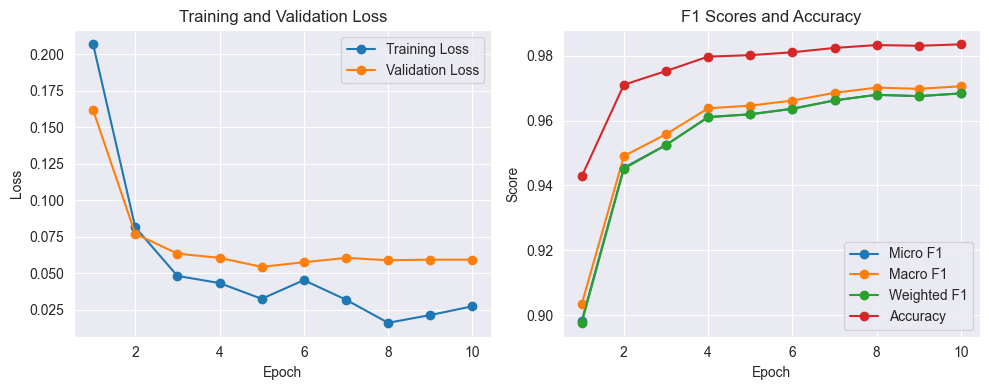

In [3]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
train_loss = [0.2068, 0.0816, 0.0483, 0.0434, 0.0326, 0.0454, 0.0320, 0.0162, 0.0215, 0.0275]
val_loss = [0.161731, 0.077158, 0.063544, 0.060650, 0.054496, 0.057645, 0.060608, 0.059021, 0.059429, 0.059412]

micro_f1 = [0.898186, 0.945447, 0.952483, 0.961084, 0.961944, 0.963664, 0.966244, 0.967964, 0.967534, 0.968394]
macro_f1 = [0.903367, 0.949052, 0.955797, 0.963801, 0.964609, 0.966179, 0.968567, 0.970179, 0.969796, 0.970601]
weighted_f1 = [0.897612, 0.945172, 0.952462, 0.961073, 0.961948, 0.963634, 0.966213, 0.967948, 0.967535, 0.968400]
accuracy = [0.942787, 0.971060, 0.975289, 0.979742, 0.980187, 0.981077, 0.982413, 0.983304, 0.983081, 0.983526]

# Courbe Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Courbe F1 & Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, micro_f1, label='Micro F1', marker='o')
plt.plot(epochs, macro_f1, label='Macro F1', marker='o')
plt.plot(epochs, weighted_f1, label='Weighted F1', marker='o')
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('F1 Scores and Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
